In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
import networkx as nx
import copy

def load_data_from_file(filename):
    """
    Load a dictionary of graphs from JSON file.
    """
    with open(filename, "r") as file_handle:
        string_dict = json.load(file_handle)
    return _load_data_from_string_dict(string_dict)

def load_data_from_string(json_string):
    """
    Load a dictionary of graphs from JSON string.
    """
    string_dict = json.loads(json_string)
    return _load_data_from_string_dict(string_dict)

def _load_data_from_string_dict(string_dict):
    result_dict = {}
    for key in string_dict:

        data = copy.deepcopy(string_dict[key])

        if 'edges' in data:
            data["links"] = data.pop("edges")

        graph = nx.node_link_graph(data)
        result_dict[key] = graph
    return result_dict

def write_data_to_json_string(graph_dict, **kwargs):
    """
    Write dictionary of graphs to JSON string.
    """
    json_string = json.dumps(graph_dict, default=nx.node_link_data, **kwargs)
    return json_string


def write_data_to_json_file(graph_dict, filename, **kwargs):
    """
    Write dictionary of graphs to JSON file.
    """
    with open(filename, "w") as file_handle:
        file_handle.write(write_data_to_json_string(graph_dict, **kwargs))

First, load unique data points

In [4]:
train_data = load_data_from_file("/content/drive/My Drive/GNN-hack/graph_data.json") # dictionary of SMILES and values are graphs
embeddings = pd.read_csv('/content/drive/My Drive/GNN-hack/final_embedding_dim30.csv')

/usr/local/lib/python3.11/dist-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


In [52]:
# Embedding IDs
embedded_atoms = list(embeddings['Atoms'])
embedded_orbitals = list(embeddings['Orbital'])

embedded_IDs = [a+','+o for a,o in zip(embedded_atoms, embedded_orbitals)]

# Embedding vectors
embedded_vectors = []

for i in range(len(embeddings)):
  a = np.fromstring(embeddings.loc[i,'Embeddings'].replace('\n','').strip('[]'), sep=' ')[:-1]

  if len(a)>30: # Noble gas elements?
    a = a[:30]

  embedded_vectors.append(a)

In [54]:
# get all the unique atom types, orbitals and their respective binding energies

atoms = []
charges = []
orbs = []
energies = []


for mol in train_data:
    graph = train_data[mol]

    atom = list(nx.get_node_attributes(graph, "atom_type").values())
    charge = list(nx.get_node_attributes(graph, "formal_charge").values())
    orb = list(nx.get_node_attributes(graph, "orbitals").values())
    energy = list(nx.get_node_attributes(graph, "binding_energies").values())

    for i in range(len(orb)):
        for j in range(len(orb[i])):
            if energy[i][j]!=-1:
                atoms.append(atom[i])
                charges.append(charge[i])
                orbs.append(orb[i][j])
                energies.append(energy[i][j])

# Also get embedding vectors for each species, if embedding exists
ids = [a+','+o for a,o in zip(atoms, orbs)]

states = []

for i in range(len(ids)):
  id = ids[i]
  if id in embedded_IDs:
    states.append(embedded_vectors[embedded_IDs.index(id)])
  else:
    states.append([0]*30)

Encode these data points, both atomic number and quantum numbers for orbitals

In [55]:
atom_dict = {
 'Li': 3,
 'B': 5,
 'C': 6,
 'N': 7,
 'O': 8,
 'F': 9,
 'Ne': 10,
 'Na': 11,
 'Mg': 12,
 'Al': 13,
 'Si': 14,
 'P': 15,
 'S': 16,
 'Cl': 17,
 'Ar': 18,
 'K': 19,
 'Ca': 20,
 'Ti': 22,
 'V': 23,
 'Cr': 24,
 'Mn': 25,
 'Fe': 26,
 'Co': 27,
 'Ni': 28,
 'Cu': 29,
 'Zn': 30,
 'Ga': 31,
 'Ge': 32,
 'As': 33,
 'Se': 34,
 'Br': 35,
 'Kr': 36,
 'Rb': 37,
 'Sr': 38,
 'Mo': 42,
 'Rh': 45,
 'Ag': 47,
 'Cd': 48,
 'In': 49,
 'Sn': 50,
 'Sb': 51,
 'Te': 52,
 'I': 53,
 'Xe': 54,
 'Cs': 55,
 'Ba': 56,
 'W': 74,
 'Re': 75,
 'Hg': 80,
 'Tl': 81,
 'Pb': 82,
 'Bi': 83,
 'U': 92
}

orb_dict = {
 '1s': [1, 0, 0],
 '2s': [2, 0, 0],
 '2p': [2, 1, 0],
 '2p3/2': [2, 1, 1.5],

 '3s': [3, 0, 0],
 '3p': [3, 1, 0],
 '3p3/2': [3, 1, 1.5],
 '3d': [3, 2, 0],
 '3d5/2': [3, 2, 2.5],

 '4s': [4, 0, 0],
 '4p3/2': [4, 1, 1.5],
 '4d': [4, 2, 0],
 '4d5/2': [4, 2, 2.5],
 '4f7/2': [4, 3, 3.5],

 '5s': [5, 0, 0],
 '5p3/2': [5, 1, 1.5],
 '5d5/2': [5, 2, 2.5],
}

orb_list = list(orb_dict.keys())

In [59]:
data = []

for i in range(len(atoms)):

    orb = orbs[i]
    orb_vec = np.zeros(len(orb_list))
    orb_vec[orb_list.index(orb)] = 1 # One-hot encoded vector

    energy = energies[i]

    state = states[i]

    if i==5179:
      print(len(state), len(orb_vec))

    row = np.concatenate((state, orb_vec, [energy]))

    data.append(row)

data = np.array(data)

30 17


Let us split into training and testing sets

In [60]:
data_train, data_test = train_test_split(data, train_size=0.8)
data_train = np.float64(data_train)
data_test = np.float64(data_test)

In [61]:
X_train = data_train[:,:-1]
y_train = data_train[:,-1]
y_train = y_train.reshape(-1, 1)

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [64]:
# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',  # or 'r2', 'neg_mean_absolute_error', etc.
    n_jobs=-1,  # use all cores
    verbose=2
)

In [65]:
# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score (neg MSE):", grid_search.best_score_)

# Best estimator (model ready for prediction)
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best parameters: {'max_depth': 10, 'n_estimators': 200}
Best score (neg MSE): -2933.3205924505583


Test set prediction

In [68]:
X_test = data_test[:,:-1]
y_pred = best_rf.predict(X_test)

y_test = data_test[:,-1]

In [69]:
np.mean((y_pred-y_test)**2)

np.float64(522.2249966785187)

Text(0, 0.5, '$y_\\mathrm{pred}-y_\\mathrm{test}$')

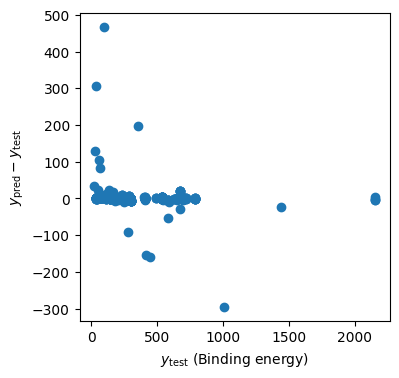

In [70]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.scatter(y_test, y_pred-y_test)
ax.set_xlabel(r'$y_\mathrm{test}$ (Binding energy)')
ax.set_ylabel(r'$y_\mathrm{pred}-y_\mathrm{test}$')